In [1]:
"""Train a simple CNN-Capsule Network on the CIFAR10 small images dataset.

Without Data Augmentation:
It gets to 75% validation accuracy in 10 epochs,
and 79% after 15 epochs, and overfitting after 20 epochs

With Data Augmentation:
It gets to 75% validation accuracy in 10 epochs,
and 79% after 15 epochs, and 83% after 30 epcohs.
In my test, highest validation accuracy is 83.79% after 50 epcohs.

This is a fast Implement, just 20s/epcoh with a gtx 1070 gpu.
"""

from __future__ import print_function

import keras
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [3]:
context = data.init()
n = 2
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data


Encoding midi-data
 []
> -> multi-track = True


ValueError: need at least one array to stack

In [23]:
n = 10
min_f = 3
max_f = 15
# x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
# x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, multiTrack=multiTrack)
x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, 
    n_polyrythms=1,
    n_channels=3,
    multiTrack=multiTrack)

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.0010416666666666
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.0072916666666667
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.996874999999999
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9906249999999999
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.0052083333333326
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.001041666666667
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.998958333333333
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.042708333333334
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.002083333333334
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.0062500000000005
 |>  100
 [INFO] : 
 |  reduced dims:
 |  (10, 100, 3)


In [24]:
n = 10
total = 1000 * 1
x_test = x_train[n:]
x_train = np.concatenate([x_train[:n] for _ in range(int(total/n))])

In [25]:
x_train = x_train.reshape(list(x_train.shape) + [1])
x_test = x_train[:-500]

In [26]:
x_train.shape

(1000, 100, 3, 1)

In [27]:
y_train = np.concatenate([list(range(n)) for _ in range(int(total/n)+1)])[:total]
y_train = keras.utils.to_categorical(y_train)
y_test = y_train[-500:]
y_train.shape

(1000, 10)

In [28]:
# the squashing function.
# we use 0.5 in stead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)

In [29]:
# https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn_capsule.py
class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    input shape :: (batch_size, input_num_capsule, input_dim_capsule)
    output shape :: (batch_size, num_capsule, dim_capsule)

    
    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            shape = (1, input_dim_capsule, self.num_capsule * self.dim_capsule)
            self.kernel = self.add_weight(
                name='capsule_kernel',
                # dense: every input connects to every input of every capsule
                shape=shape,
                    initializer='glorot_uniform',
                    trainable=True)
            print('shared weights, shape =',shape, np.prod(shape))
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                # b = K.batch_dot(o, hat_inputs, [2, 3])
                b += K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [30]:
num_classes = 10
m = 9000

In [31]:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# x_train = x_train[:m].astype('float32')
# x_test = x_test[:1000].astype('float32')
# y_train = y_train[:m]
# y_test = y_train[:1000]
# x_train /= 255
# x_test /= 255
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

In [32]:
x_train.shape

(1000, 100, 3, 1)

In [33]:
y_train.shape

(1000, 10)

m (30, 3)


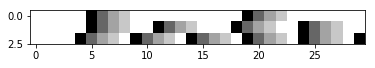

In [34]:
# plt.imshow(x_train[0,:,:,0])
plot.multi(x_train[0,:30,:,0])

In [35]:
# A common Conv2D model
n_channels = x_train.shape[-1]
n_notes = x_train.shape[-2]
kernel_size = (3,3) if n_notes > 27 else (3,1)

input_image = Input(shape=(None, None, n_channels))
x = input_image
# print(K.int_shape(x))
x = Reshape((-1, 1))(x)
x = Conv1D(64, 3, activation='relu')(x)
x = Conv1D(64, 3, activation='relu')(x)
x = AveragePooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = Conv1D(128, 3, activation='relu')(x)
x = Reshape((-1, 1,1))(x)


# x = Reshape(x_train.shape[:-1])(x)
# x = Conv2D(64, (3,3), activation='relu')(input_image)
# x = Conv2D(64, kernel_size, activation='relu')(x)
# x = AveragePooling2D((2, 2))(x)
# x = Conv2D(128, kernel_size, activation='relu')(x)
# x = Conv2D(128, kernel_size, activation='relu')(x)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x = Reshape((-1, 128))(x)
capsule = Capsule(10, 16, 3, True)(x)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=input_image, outputs=output)

shape (1, 128, 160) 20480


In [36]:
# we use a margin loss
model.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
reshape_4 (Reshape)          (None, None, 1)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          256       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
average_pooling1d_2 (Average (None, None, 64)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 128)         24704     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 128)         49280     
__________

In [37]:
phase_mod = 0.
whitening = False

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
#         zca_epsilon=10,
        zca_whitening=whitening,
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.,  # note-channel mod, but not shuffled
        height_shift_range=phase_mod,  # start_t, phase
        horizontal_flip=False,  # reverse
        vertical_flip=False)

datagen.fit(x_train)

In [46]:
batch_size = 128
epochs = 15

In [47]:
# we can compare the performance with or without data augmentation
data_augmentation = False
data_augmentation = True

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        shuffle=True)
else:
    print('Using real-time data augmentation.')    
    history = model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        workers=4)


Using real-time data augmentation.
Epoch 1/15
8/8 [==============================] - 5s 612ms/step - loss: 0.4429 - acc: 0.3803 - val_loss: 0.4167 - val_acc: 0.5000
Epoch 2/15
8/8 [==============================] - 4s 541ms/step - loss: 0.4089 - acc: 0.4071 - val_loss: 0.3938 - val_acc: 0.6000
Epoch 3/15
8/8 [==============================] - 4s 527ms/step - loss: 0.3863 - acc: 0.5594 - val_loss: 0.3726 - val_acc: 0.6000
Epoch 4/15
8/8 [==============================] - 5s 577ms/step - loss: 0.3617 - acc: 0.6751 - val_loss: 0.3461 - val_acc: 0.6000
Epoch 5/15
8/8 [==============================] - 5s 599ms/step - loss: 0.3392 - acc: 0.7431 - val_loss: 0.3263 - val_acc: 0.7000
Epoch 6/15
8/8 [==============================] - 5s 624ms/step - loss: 0.3210 - acc: 0.7836 - val_loss: 0.3060 - val_acc: 0.8000
Epoch 7/15
8/8 [==============================] - 5s 573ms/step - loss: 0.3007 - acc: 0.8949 - val_loss: 0.2883 - val_acc: 0.9000
Epoch 8/15
8/8 [==============================] - 4s 51

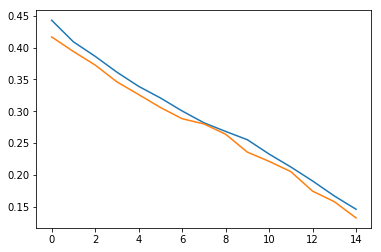

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

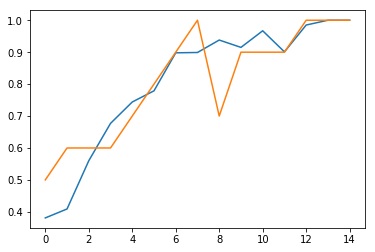

In [49]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

m (30, 3)


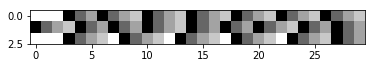

m (30, 3)


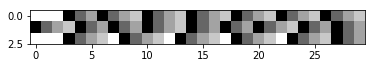

In [50]:
i = 1
x = datagen.random_transform(x_train[i])
plot.multi(x[:30,:,0])
plot.multi(x_train[i,:30,:,0])

m (30, 3)


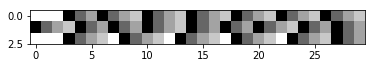

m (30, 3)


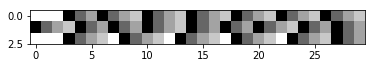

In [51]:
i = 1
x = datagen.standardize(x_train[i:i+batch_size])
x.shape
x = x[0]
plot.multi(x[:30,:,0])
plot.multi(x_train[i,:30,:,0])

In [52]:
# plt.imshow(x[:,:,0])

In [53]:
# plt.imshow(x_train[i,:,:,0])